In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset

In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
df= pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.shape

(1600000, 6)

Sampling the dataset

In [4]:
df_sampled = df.groupby('sentiment')[['sentiment', 'text']].sample(n=50000, random_state=1)
df_sampled.reset_index(inplace=True)
df_sampled

,index,sentiment,text
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so..."
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...
2,2028,0,"I don't want to be cold in April, but I am"
3,669856,0,@JaredOngie haha its too cold down here bt ot...
4,458897,0,Upset I can't find my CHI!
...,...,...,...
99995,1006064,4,Off in a bit to meet Spuds new family at his f...
99996,1497567,4,watching videos in youtube about Drake Bell..
99997,1506693,4,who wants to go to the laker parade with me
99998,1061627,4,@BELAI83 i'm great!!!hang out but i have to co...


<Axes: xlabel='sentiment'>

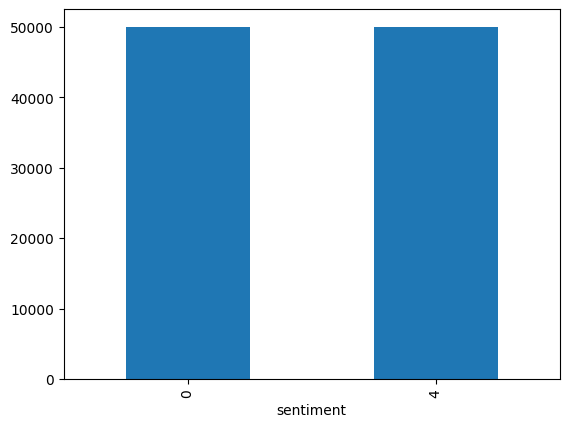

In [5]:
df_sampled.groupby(['sentiment']).size().plot(kind='bar')

In [6]:
df_sampled.isnull().sum()

index        0
sentiment    0
text         0
dtype: int64

WordCloud

In [7]:
!pip install wordcloud

In [8]:
# from wordcloud import WordCloud
# plt.figure(figsize=(20, 10))

# # Combine all text entries from the 'text' column of your dataframe into a single string
# text_combined = " ".join(cat for cat in df_sampled.text)
# word_cloud = WordCloud(
#     collocations=False, 
#     background_color='white', 
#     width=2000, 
#     height=1000
# ).generate(text_combined)

# # Display the generated Word Cloud
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis("off")  # Turn off the axis numbers and labels
# plt.show()  # Display the plot

Preprocessing 

1. Lower case
2. Removing urls
3. Removing usernames
4. Replace emojis
5. Remove the chat words and numbers(e.g lol to laugh out loud , 1 to one)
6. replace contractions
7. Remove punctuations
8. Lemmatization and replace consecutive letters
9. Remove stopwords

In [9]:
from num2words import num2words
slangDf = pd.read_csv("slang.csv")
slangDf=slangDf[['acronym','expansion']]
slangDf.head()


,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [10]:
def replace_chat_words(text):
    normal_word=slangDf[slangDf['acronym'].isin([text])]['expansion'].values
    if len(normal_word)>=1:
        if text=='lol':
            return normal_word[1]
        else:
            return normal_word[0]
    elif text.isnumeric():
        return num2words(text)
    else:
        return text
    
replace_chat_words('lol')

'laughing out loud'

In [11]:
import re
import emoji
import contractions as con
import string
import en_core_web_lg
# pip install spacy
# python -m spacy download en_core_web_lg
from autocorrect import Speller

nlp=en_core_web_lg.load()
speller=Speller(lang='en')
stop_words=nlp.Defaults.stop_words

def preprocessingText(text):
  text = text.lower()
  # Remove urls
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  # # Remove usernames
  text = re.sub(r'@[^\s]+','', text)
  # # Replace all emojis from the emoji shortcodes
  text = emoji.demojize(text)
  # # Replace chat words and numbers
  text = " ".join([replace_chat_words(word) for word in text.split()])
  # Replace contraction words
  text=con.fix(text)
  # Remove punctuations
  text = "".join([i for i in text if i not in string.punctuation])
  # Replace 3 or more consecutive letters by 1 letter and lemmatizing the words
  text = " ".join([re.sub(r"(.)\1\1+", r"\1", str(token)) if token.pos_ in ["PROPN", 'NOUN'] else token.lemma_ for token in nlp(text)])
  # Replace misspelled words
  text=speller(text)
  # Remove stopwords
  text = " ".join([word for word in text.split() if word not in stop_words])

  text = text.strip()

  return text


In [12]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext,Row 

conf=SparkConf()
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc=SparkContext(conf=conf)
sqlContext=SQLContext(sc)


23/11/15 21:04:55 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.234.128 instead (on interface ens33)
23/11/15 21:04:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/11/15 21:04:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [13]:
df=sqlContext.read.csv('training.1600000.processed.noemoticon.csv',header=True)
df=df.rdd
df=df.map(lambda x:(x[0],x[5]))
df_processed=df.map(lambda x:(0 if x[0]=='0' else 1,preprocessingText(x[1])))


In [14]:
df_processed=df_processed.toDF(["sentiment", "text"]).distinct()

In [15]:
df_processed.toPandas()

23/11/15 21:16:22 ERROR Executor: Exception in task 6.0 in stage 2.0 (TID 8)/ 8]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_5822/1261530550.py", line 4, in <lambda>
  File "/tmp/ipykernel_5822/898944990.py", line 23, in preprocessingText
  File "/tmp/ipykernel_5822/

Py4JJavaError: An error occurred while calling o69.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:97)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:93)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 2.0 failed 1 times, most recent failure: Lost task 6.0 in stage 2.0 (TID 8) (192.168.234.128 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_5822/1261530550.py", line 4, in <lambda>
  File "/tmp/ipykernel_5822/898944990.py", line 23, in preprocessingText
  File "/tmp/ipykernel_5822/898944990.py", line 23, in <listcomp>
  File "/tmp/ipykernel_5822/3417128140.py", line 9, in replace_chat_words
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/num2words/__init__.py", line 95, in num2words
    number = converter.str_to_number(number)
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/num2words/base.py", line 101, in str_to_number
    return Decimal(value)
decimal.InvalidOperation: [<class 'decimal.ConversionSyntax'>]

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:3629)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:3633)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:3610)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:3610)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:3609)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:139)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:141)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:136)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:113)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:107)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:68)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:68)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_5822/1261530550.py", line 4, in <lambda>
  File "/tmp/ipykernel_5822/898944990.py", line 23, in preprocessingText
  File "/tmp/ipykernel_5822/898944990.py", line 23, in <listcomp>
  File "/tmp/ipykernel_5822/3417128140.py", line 9, in replace_chat_words
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/num2words/__init__.py", line 95, in num2words
    number = converter.str_to_number(number)
  File "/home/kevinzhu224/.local/lib/python3.8/site-packages/num2words/base.py", line 101, in str_to_number
    return Decimal(value)
decimal.InvalidOperation: [<class 'decimal.ConversionSyntax'>]

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


23/11/15 21:16:24 WARN TaskSetManager: Lost task 7.0 in stage 2.0 (TID 9) (192.168.234.128 executor driver): TaskKilled (Stage cancelled)
23/11/15 21:16:25 WARN PythonRunner: Incomplete task 0.0 in stage 2 (TID 2) interrupted: Attempting to kill Python Worker
23/11/15 21:16:25 WARN TaskSetManager: Lost task 0.0 in stage 2.0 (TID 2) (192.168.234.128 executor driver): TaskKilled (Stage cancelled)
23/11/15 21:16:25 WARN PythonRunner: Incomplete task 1.0 in stage 2 (TID 3) interrupted: Attempting to kill Python Worker
23/11/15 21:16:25 WARN TaskSetManager: Lost task 1.0 in stage 2.0 (TID 3) (192.168.234.128 executor driver): TaskKilled (Stage cancelled)
23/11/15 21:16:25 WARN PythonRunner: Incomplete task 5.0 in stage 2 (TID 7) interrupted: Attempting to kill Python Worker
23/11/15 21:16:25 WARN TaskSetManager: Lost task 5.0 in stage 2.0 (TID 7) (192.168.234.128 executor driver): TaskKilled (Stage cancelled)
23/11/15 21:16:25 WARN PythonRunner: Incomplete task 4.0 in stage 2 (TID 6) interr